In [3]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    f1_score, roc_auc_score, ConfusionMatrixDisplay
)
from scipy.special import gamma
warnings.filterwarnings('ignore')

os.makedirs('../results',exist_ok=True)
os.makedirs('../models',exist_ok=True)

sns.set_theme('paper')

data = pd.read_csv('../data/Heart_Disease.csv')

Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


# Spliting the data


In [4]:
X = data.drop('target',axis=1)
y = data['target']

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and evaluating baseline KNN model

In [5]:
sns.set_theme(style='whitegrid')
def train_evaluate_knn(X_train, X_test, y_train, y_test, scaling=False, **kwargs):
    if scaling:
        scaler = StandardScaler()
        X_train_scaled= scaler.fit_transform(X_train)
        X_test_scaled= scaler.transform(X_test)
        print("\nRunning KNN with scaling.")
        X_train_use ,X_test_use = X_train_scaled, X_test_scaled
    else:
        print("\nRunning KNN without scaling.")
        X_train_use ,X_test_use = X_train, X_test

    knn_model = KNeighborsClassifier(**kwargs)
    knn_model.fit(X_train_use,y_train)

    y_pred = knn_model.predict(X_test_use)
    y_prob = knn_model.predict_proba(X_test_use)[:,1] # type: ignore

    acc = accuracy_score(y_test,y_pred)
    f1 = f1_score(y_test,y_pred)
    auc = roc_auc_score(y_test,y_pred)

    cv_acc = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='accuracy').mean()
    cv_f1 = cross_val_score(knn_model,X_train_use, y_train, cv=5, scoring='f1').mean()
    cv_auc = cross_val_score(knn_model, X_train_use, y_train, cv=5, scoring='roc_auc').mean()

    clr = classification_report(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print(f"\nAccuracy (Test): {acc:.4f} | CV: {cv_acc:.4f}")
    print(f"F1-Score (Test): {f1:.4f} | CV: {cv_f1:.4f}")
    print(f"AUC (Test): {auc:.4f} | CV-AUC: {cv_auc:.4f}")
    
    print("\nClassification Report:\n", clr)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix -KNN {'Scaled' if scaling else 'Unscaled'}')
    plt.savefig(f'../results/cm_KNN_{'Scaled' if scaling else 'Unscaled'}.png', dpi=300)
    plt.close()

    return{
        'model':knn_model,
        'scaler':scaler if scaling else None,
        'X_train_use':X_train_use,
        'X_test_use':X_test_use,
        'Accuracy':acc,
        'F1':f1,
        'AUC': auc,
        'CV_Acc':cv_acc,
        'CV_F1':cv_f1,
        'CV_AUC': cv_auc,
        'Confusion_matrix':cm,
        'Classification_report':clr,
    }

In [6]:
print("****** Results of the Baseline KNN Model ******")
result_unscaled = train_evaluate_knn(X_train, X_test, y_train, y_test, scaling=False)
result_scaled = train_evaluate_knn(X_train, X_test, y_train, y_test, scaling=True)

****** Results of the Baseline KNN Model ******

Running KNN without scaling.

Accuracy (Test): 0.7017 | CV: 0.7049
F1-Score (Test): 0.7280 | CV: 0.7255
AUC (Test): 0.6984 | CV-AUC: 0.7553

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.64      0.67       112
           1       0.70      0.75      0.73       126

    accuracy                           0.70       238
   macro avg       0.70      0.70      0.70       238
weighted avg       0.70      0.70      0.70       238


Running KNN with scaling.

Accuracy (Test): 0.8361 | CV: 0.8488
F1-Score (Test): 0.8494 | CV: 0.8575
AUC (Test): 0.8338 | CV-AUC: 0.9042

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82       112
           1       0.83      0.87      0.85       126

    accuracy                           0.84       238
   macro avg       0.84      0.83      0.83       238
weighted avg       0.84 

# OOA Implementation (adapted from Octopus optimization Algorithm article)
### Levy Flight helper (Eq. 13-14 from article)

In [7]:
def levy_flight(dim, beta=1.5):
    numerator = gamma(1 + beta) * np.sin((np.pi * beta)/2)
    denomenator = gamma((1 + beta) /2) * beta * (2 ** ((beta-1) /2))
    sigma = (numerator / denomenator) ** (1/beta)
    u = np.random.normal(0, 1, dim)
    v = np.random.normal(0,1, dim)
    step = 0.01 * ((u * sigma) / (np.abs(v) ** (1/beta)))

    return step

In [8]:
sns.set_theme('paper')  
def ooa_optimizer(obj_func, lb, ub, dim=2, N=30, max_iter=80, Nh=20, Ns=10, vr=3, ll=0.8, verbose=True):
    np.random.seed(42)

    if Nh <= 0 or Ns < 0 or Nh + Ns > N:
        raise ValueError("Invalid Nh/Ns: require Nh>0, Ns>=0 and Nh+Ns <= N")

    # Initialize population
    pop = np.random.uniform(lb, ub, size=(N, dim))
    fitness = np.array([obj_func(ind) for ind in pop])

    # Deviding the population into hunters and scouts
    # each hunter has a head and 8 tentacles
    hunters = []
    for i in range(Nh):
        head = pop[i].copy()
        head_fit = fitness[i]
        
        tentacles = head + np.random.uniform(-ll, ll, size=(8, dim))
        tent_fits = np.array([obj_func(t) for t in tentacles])
        hunters.append({
            "head": head,
            "head_fit": head_fit,
            "tentacles": tentacles,
            "tent_fits": tent_fits
        })

    # Best global
    best_idx = np.argmin(fitness)
    best_pos = pop[best_idx].copy()
    best_fit = fitness[best_idx]

    history = [best_fit]

    for t in range(1, max_iter + 1):
        ld = vr * (1.0 - t / max_iter)  
        trans = (2 * np.random.rand() - 1) * ld
        
        # Update hunters and their tentacles
        for i, hunter in enumerate(hunters):
            head = hunter["head"]
            old_head = head.copy()
            # one tentacle retains previous head as short-term memory
            memory_idx = 0
            hunter["tentacles"][memory_idx] = old_head.copy()
            hunter["tent_fits"][memory_idx] = hunter["head_fit"]

            for j in range(8):
                tent = hunter["tentacles"][j].copy()
                
                closest_idx = np.argmin(np.linalg.norm(hunter["tentacles"] - best_pos, axis=1))
                closest_tent = hunter["tentacles"][closest_idx].copy()
                
                if abs(trans) < ll:
                    new_tent = tent + np.random.rand() * (best_pos - closest_tent) * levy_flight(dim)
                    
                else:
                    new_tent = hunter["head"] + np.random.rand() * (hunter["head"] - tent) * levy_flight(dim)

                new_tent = np.clip(new_tent, lb, ub)
                new_fit = obj_func(new_tent)

                if new_fit < hunter["tent_fits"][j]:
                    hunter["tentacles"][j] = new_tent
                    hunter["tent_fits"][j] = new_fit

            # modify head position to its optimal tentacle
            best_tent_idx = np.argmin(hunter["tent_fits"])
            if hunter["tent_fits"][best_tent_idx] < hunter["head_fit"]:
                hunter["head"] = hunter["tentacles"][best_tent_idx].copy()
                hunter["head_fit"] = hunter["tent_fits"][best_tent_idx]

            # update global best
            if hunter["head_fit"] < best_fit:
                best_fit = hunter["head_fit"]
                best_pos = hunter["head"].copy()

        
        hunter_heads = np.array([h["head"] for h in hunters])
        hunter_head_fits = np.array([h["head_fit"] for h in hunters])

        # choose Ns positions consisting of the best, the worst and Ns - 2 random positions from hunters
        best_h_idx = np.argmin(hunter_head_fits)
        worst_h_idx = np.argmax(hunter_head_fits)

        chosen_heads = []
        chosen_indices = []
        
        if Ns > 0:
            chosen_heads.append(hunter_heads[best_h_idx].copy())
            chosen_indices.append(best_h_idx)
            if Ns > 1:
                chosen_heads.append(hunter_heads[worst_h_idx].copy())
                chosen_indices.append(worst_h_idx)
            
            remaining = Ns - len(chosen_heads)
            if remaining > 0:
                pool = [i for i in range(len(hunters)) if i not in chosen_indices] # getting the rest of the hunters
                sel = list(np.random.choice(pool, size=remaining, replace=False)) # selecting randomly from them
                for s in sel:
                    chosen_heads.append(hunter_heads[s].copy())
                    chosen_indices.append(s)

            # create scouts based on chosen_heads 
            scouts = []
            for ch in chosen_heads:
                new_pos = ch + np.random.rand() * ld * (ub + lb - 2 * ch)
                new_pos = np.clip(new_pos, lb, ub)
                scouts.append(new_pos)

            for sc_pos, h_idx in zip(scouts, chosen_indices):
                sc_fit = obj_func(sc_pos)
                if sc_fit < hunters[h_idx]["head_fit"]:
                    # convert scout to hunter
                    hunters[h_idx]["head"] = sc_pos.copy()
                    hunters[h_idx]["head_fit"] = sc_fit
                    new_tentacles = np.random.rand(8, dim) * (sc_pos + ll) - (sc_pos - ll)
                    hunters[h_idx]["tentacles"] = np.clip(new_tentacles, lb, ub)
                    hunters[h_idx]["tent_fits"] = np.array([obj_func(t) for t in hunters[h_idx]["tentacles"]])

                    # update global best if needed
                    if sc_fit < best_fit:
                        best_fit = sc_fit
                        best_pos = sc_pos.copy()
                        
        history.append(best_fit)

        if verbose and t % 20 == 0:
            print(f"Iteration {t}: Best fitness = {best_fit:.4f}")


    plt.figure(figsize=(8,5))
    plt.plot(history)
    plt.xlabel('Iteration')
    plt.ylabel('Best fitness (minimization)')
    plt.title(f'OOA fitness over {max_iter} iterations')
    plt.show()

    return best_pos, best_fit

In [9]:
scaler_ooa = StandardScaler()
X_train_scaled = scaler_ooa.fit_transform(X_train)
X_test_scaled = scaler_ooa.transform(X_test)

In [19]:
metric_map = {1: 'euclidean', 2: 'manhattan', 3: 'chebyshev', 4:'minkowski', 5:'hamming', 6:'cosine'}
weight_map = {1: 'uniform', 2: 'distance'}

def knn_objective(params):
    k = int(np.clip(params[0],2,30))  
    p = np.clip(params[1],1,3)
    metric_idx = int(np.clip(params[2], 1, 6))
    weight_idx = int(np.clip(params[3], 1, 2))

    metric = metric_map[metric_idx]
    weights = weight_map[weight_idx]

    knn =KNeighborsClassifier(n_neighbors=k, p=p, metric=metric,weights=weights)  # type: ignore
    
    cv_acc = cross_val_score(knn, X_train_scaled, y_train,cv=5, scoring='accuracy').mean()

    return 1 - cv_acc # minimizing 


**** OOA Optimazation (CV based) ****
Iteration 20: Best fitness = 0.0956
Iteration 40: Best fitness = 0.0935
Iteration 60: Best fitness = 0.0935
Iteration 80: Best fitness = 0.0935


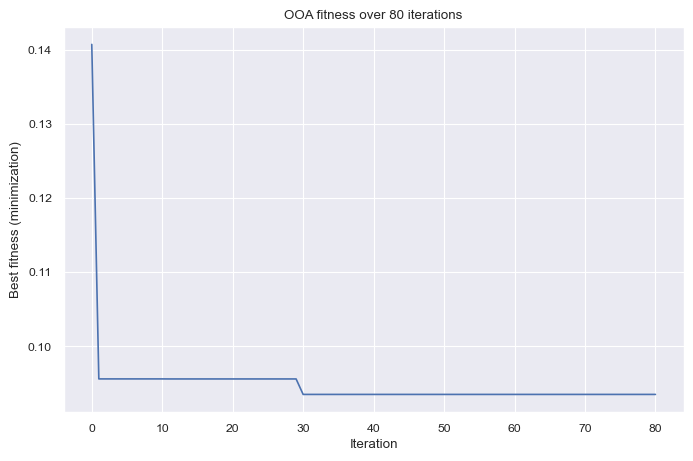


Best OOA Params : k = 13, p = 1.18, metric = manhattan, weights = distance
Best OOA CV Accuracy:0.0935


In [11]:
import time
lb = np.array([1, 1, 1, 1])
ub = np.array([30, 3, 3, 2])
dim = 4

print("\n**** OOA Optimazation (CV based) ****")
start = time.time()
best_params, best_cv_acc = ooa_optimizer(knn_objective, lb, ub, dim, N=30, max_iter=80) 
end = time.time()
best_k, best_p, best_metric_idx, best_weight_idx  = int(best_params[0]), best_params[1], int(best_params[2]), int(best_params[3])

best_metric = metric_map[best_metric_idx]
best_weight = weight_map[best_weight_idx]

print(f"\nBest OOA Params : k = {best_k}, p = {best_p:.2f}, metric = {best_metric}, weights = {best_weight}")
print(f"Best OOA CV Accuracy:{best_cv_acc:.4f}")
RESULTS = open('results.txt', 'a+')
RESULTS.write(f'Time for finding best parameters: {end - start:.4f}\n')
RESULTS.write(f'Accuracy: {best_cv_acc:.4f}')
RESULTS.close()

In [12]:
knn_opt = KNeighborsClassifier(n_neighbors=best_k, p=best_p, metric=best_metric,weights=best_weight) # type: ignore
knn_opt.fit(X_train_scaled,y_train)

y_pred_opt = knn_opt.predict(X_test_scaled)
y_prob_opt = knn_opt.predict_proba(X_test_scaled)[:,1] # type: ignore

acc_opt = accuracy_score(y_test,y_pred_opt)
f1_opt = f1_score(y_test,y_pred_opt)
auc_opt = roc_auc_score(y_test, y_prob_opt)

cv_acc_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='accuracy').mean()
cv_f1_opt = cross_val_score(knn_opt,X_train_scaled,y_train,cv=5,scoring='f1').mean()
cv_auc_opt = cross_val_score(knn_opt, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()

cm_opt = confusion_matrix(y_test, y_pred_opt)
clr_opt = classification_report(y_test, y_pred_opt)

In [13]:
train_acc = accuracy_score(y_train, knn_opt.predict(X_train_scaled))
print(f"Overfit checker : Train acc={train_acc:.4f}  vs Test= {acc_opt:.4f} (Diff < 0.05 -->ok)")

Overfit checker : Train acc=1.0000  vs Test= 0.9538 (Diff < 0.05 -->ok)


In [20]:
import IFOX
from mealpy import FloatVar

problem = {
    "bounds": FloatVar(lb=[2, 1, 1, 1], ub=[30, 3, 6, 2]), #type: ignore
    "obj_func": knn_objective,
    "minmax": "min",
    "name": "KNN_Optimization",
    "log_to": "console",
}


ifox = IFOX.IFOX(epoch=80, pop_size=30, name = 'IFOX') # type: ignore
best_solution_ifox = ifox.solve(problem)
print(f"Best parameters: {best_solution_ifox.solution}")
print(f"Best fitness: {best_solution_ifox.target.fitness}")

2025/11/29 07:27:56 PM, INFO, IFOX.IFOX: Solving single objective optimization problem.
2025/11/29 07:28:08 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 1, Current best: 0.09663268117938828, Global best: 0.09663268117938828, Runtime: 6.03142 seconds
2025/11/29 07:28:14 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 2, Current best: 0.09663268117938828, Global best: 0.09663268117938828, Runtime: 6.15229 seconds
2025/11/29 07:28:20 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 3, Current best: 0.09663268117938828, Global best: 0.09663268117938828, Runtime: 5.80813 seconds
2025/11/29 07:28:26 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 4, Current best: 0.09663268117938828, Global best: 0.09663268117938828, Runtime: 6.46483 seconds
2025/11/29 07:28:32 PM, INFO, IFOX.IFOX: >>>Problem: KNN_Optimization, Epoch: 5, Current best: 0.09138054560484987, Global best: 0.09138054560484987, Runtime: 5.88965 seconds
2025/11/29 07:28:38 PM, INFO, IFOX.IF

Best parameters: [9.79762751 1.86605911 5.53313975 2.        ]
Best fitness: 0.09138054560484987


In [21]:
best_k_ifox, best_p_ifox, best_metric_idx_ifox, best_weight_idx_ifox = int(best_solution_ifox.solution[0]), best_solution_ifox.solution[1], int(best_solution_ifox.solution[2]), int(best_solution_ifox.solution[3])

best_metric_ifox = metric_map[best_metric_idx]
best_weight_ifox = weight_map[best_weight_idx]

knn_ifox = KNeighborsClassifier(n_neighbors=best_k_ifox, p=best_p_ifox, metric=best_metric_ifox, weights=best_weight_ifox) # type: ignore
knn_ifox.fit(X_train_scaled, y_train)

y_pred_ifox = knn_ifox.predict(X_test_scaled)
y_prob_ifox = knn_ifox.predict_proba(X_test_scaled)[:,1] # type: ignore

acc_ifox = accuracy_score(y_test,y_pred_ifox)
f1_ifox = f1_score(y_test,y_pred_ifox)
auc_ifox = roc_auc_score(y_test, y_prob_ifox)

cv_acc_ifox = cross_val_score(knn_ifox, X_train_scaled, y_train, cv=5, scoring='accuracy').mean()
cv_f1_ifox = cross_val_score(knn_ifox, X_train_scaled, y_train, cv=5, scoring='f1').mean()
cv_auc_ifox = cross_val_score(knn_ifox, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()

cm_ifox = confusion_matrix(y_test, y_pred_ifox)
clr_ifox = classification_report(y_test, y_pred_ifox)

In [22]:
print(f"\nOOA-KNN Test Acc:{acc_opt:.4f} | CV-acc: {cv_acc_opt:.4f}")
print(f"OOA-KNN Test F1:{acc_opt:.4f} | CV-f1: {cv_f1_opt:.4f}")
print(f"OOA-KNN Test AUC: {auc_opt:.4f} | CV-AUC: {cv_auc_opt:.4f}")


OOA-KNN Test Acc:0.9538 | CV-acc: 0.9065
OOA-KNN Test F1:0.9538 | CV-f1: 0.9124
OOA-KNN Test AUC: 0.9718 | CV-AUC: 0.9556


In [23]:
print("\nOOA Classification Report:\n", clr_opt)


OOA Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       112
           1       0.96      0.95      0.96       126

    accuracy                           0.95       238
   macro avg       0.95      0.95      0.95       238
weighted avg       0.95      0.95      0.95       238



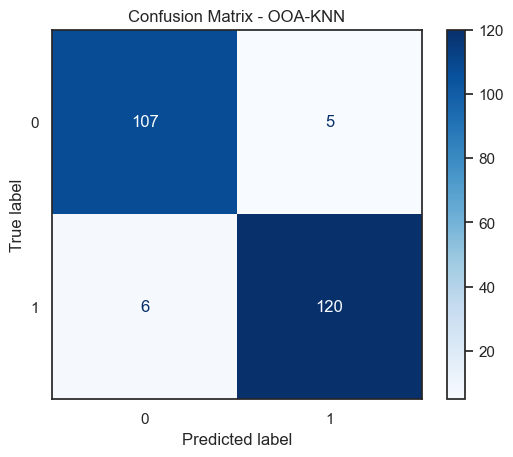

In [24]:
sns.set_theme(style='white')
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt)
disp_opt.plot(cmap='Blues')
plt.title('Confusion Matrix - OOA-KNN')
plt.savefig('../results/cm_ooa_knn.png', dpi=300)
plt.show()

In [25]:
#comparision table 
print("\n***** Performance Comparision ****")
comparison_data = {
    'Model': ['KNN Unscaled','KNN Scaled','OOA-KNN (Optimized)', 'IFOX-KNN'],
    'Test Acc': [result_unscaled['Accuracy'], result_scaled['Accuracy'], acc_opt, acc_ifox],
    'Test F1': [result_unscaled['F1'], result_scaled['F1'], f1_opt, f1_ifox],
    'Test AUC':[result_unscaled['AUC'], result_scaled['AUC'], auc_opt, auc_ifox],
    'CV Acc': [result_unscaled['CV_Acc'], result_scaled['CV_Acc'], cv_acc_opt, cv_acc_ifox],
    'CV F1': [result_unscaled['CV_F1'], result_scaled['CV_F1'], cv_f1_opt, cv_f1_ifox],
    'CV AUC':[result_unscaled['CV_AUC'], result_scaled['CV_AUC'], cv_auc_opt, cv_auc_ifox]
}
comparision = pd.DataFrame(comparison_data)
print(comparision.round(4))


***** Performance Comparision ****
                 Model  Test Acc  Test F1  Test AUC  CV Acc   CV F1  CV AUC
0         KNN Unscaled    0.7017   0.7280    0.6984  0.7049  0.7255  0.7553
1           KNN Scaled    0.8361   0.8494    0.8338  0.8488  0.8575  0.9042
2  OOA-KNN (Optimized)    0.9538   0.9562    0.9718  0.9065  0.9124  0.9556
3             IFOX-KNN    0.9454   0.9482    0.9690  0.8992  0.9048  0.9525


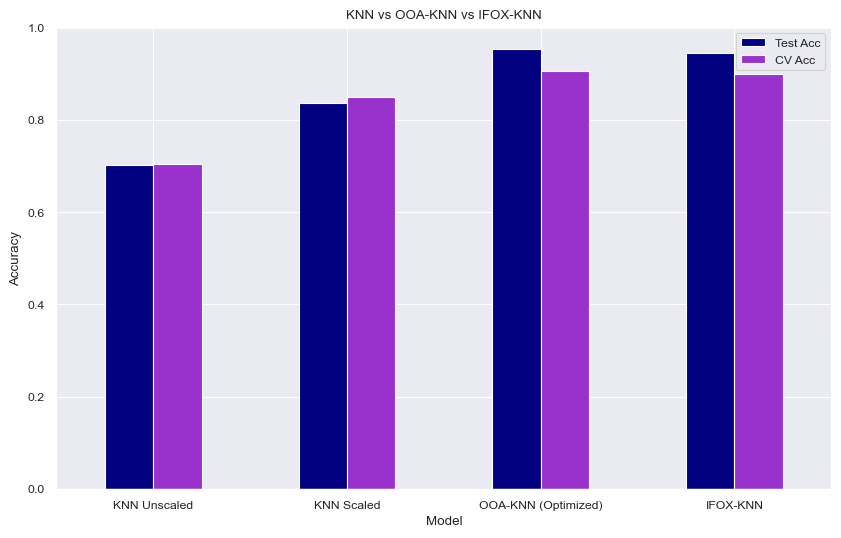

In [ ]:
sns.set_theme('paper')
comparision.set_index('Model')[['Test Acc','CV Acc']].plot(kind='bar', figsize=(10,6), color=['navy', 'darkorchid'])
plt.title('KNN vs OOA-KNN vs IFOX-KNN')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend()
plt.savefig('../results/performance_comparison.png', dpi=300)
plt.show()

In [ ]:
# joblib.dump(knn_opt, '../models/ooa_knn_model.joblib')